# Определение возраста по фотографии

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы
анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы, а также контролировать добросовестность кассиров при продаже алкоголя.
Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

В качестве исходных данных будем использовать размеченный набор фотографий `appa-real-face-cropped`.

# Импорт библиотек и данных

Импортируем библиотеки.

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AveragePooling2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Nadam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

Фотографии хранятся в папке `final_files`. Реальный возраст человека на фотографии и название файла сопоставляются в `labels`.


In [13]:
try:
    faces_path = '/kaggle/input/appa-real-face-cropped/final_files/final_files'
    labels_path = '/kaggle/input/appa-real-face-cropped/labels.csv'
    labels = pd.read_csv(labels_path)
except:
    faces_path = '/datasets/faces/final_files/'
    labels_path = '/datasets/faces/labels.csv'
    labels = pd.read_csv(labels_path)

# Анализ данных

Посмотрим на общую информацию и рспределение возраста.

In [16]:
labels.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 7591 entries, 0 to 7590

Data columns (total 2 columns):

 #   Column     Non-Null Count  Dtype 

---  ------     --------------  ----- 

 0   file_name  7591 non-null   object

 1   real_age   7591 non-null   int64 

dtypes: int64(1), object(1)

memory usage: 118.7+ KB


В нашем распоряжении 7591 фотография с разметкой возраста.

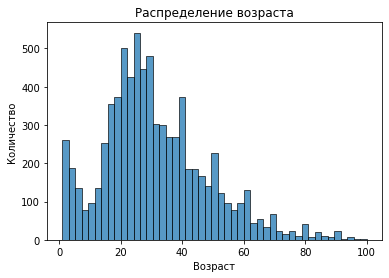

In [23]:
sns.histplot(labels.real_age)
plt.title('Распределение возраста')
plt.ylabel('Количество')
plt.xlabel('Возраст')
plt.show()

Судя по распределению больше всего данных приходися на людей среднего возраста, недостаток людей младше 10 лет и старше 60 лет негатвино скажется на качестве моедли.

# Построение модели

Определим следующие функции для дальнейшей работы

*   `load_data` - функция для выгрузки данных батчами, эти данные будут поступать на вход модели;
*   `create_model` - функция для создания модели;
*   `train_model` - функция для тренировки модели;
*   `plot_metrics` - функция для визуализации метрик качества.


In [11]:
def load_data(subset, faces_path=faces_path, labels_path=labels_path, validation_split=0.25, target_size=(224, 224), batch_size=32):

    dataframe = pd.read_csv(labels_path)

    if subset =='training':
        datagen = ImageDataGenerator(rescale=1.0/255,
                                     validation_split=validation_split,
#                                        horizontal_flip=True,
#                                        vertical_flip=True,
#                                        rotation_range=90,
#                                        width_shift_range=0.2,
#                                        height_shift_range=0.2
                                    )
    if subset =='validation':
        datagen = ImageDataGenerator(rescale=1.0/255,
                                     validation_split=validation_split
                                    )

    gen_flow = datagen.flow_from_dataframe(dataframe,
                                           directory=faces_path,
                                           x_col='file_name',
                                           y_col='real_age',
                                           target_size=target_size,
                                           class_mode='raw',
                                           batch_size=batch_size,
                                           shuffle=True,
                                           seed=12345,
                                           subset=subset
                                          )

    print(subset, 'loaded')
    return gen_flow


def create_model(input_shape=(224, 224, 3), weights='imagenet', loss='mean_squared_error', metrics=['mean_absolute_error']):

    backbone = ResNet50(input_shape=input_shape,
                        weights=weights,
                        include_top=False
                       )

    optimizer = Nadam(learning_rate=0.0002)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    print('model created')
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=1,
               steps_per_epoch=None, validation_steps=None):

    monitor = 'val_mean_absolute_error'
    reducer = ReduceLROnPlateau(monitor=monitor, mode='min', factor=0.5, patience=5, min_lr=0.00001, verbose=1)
    stopper = EarlyStopping(monitor=monitor, patience=15, mode='min', min_delta=0.001, verbose=1)
    checkpointer = ModelCheckpoint(monitor=monitor,
                                   mode='min',
                                   verbose=1
                                  )
    callbacks = [reducer, stopper]

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              callbacks=callbacks,
              shuffle=True
             )
    print('model trained')
    return model


def plot_metrics(model):

    plt.plot(model.history.history['mean_absolute_error'])
    plt.plot(model.history.history['val_mean_absolute_error'])
    plt.title('Model mae')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

Загружаем тренировочный и валидационный батчи.

In [ ]:
train_data = load_data(subset='training')
test_data = load_data(subset='validation')

features_train, target_train = next(train_data)
features_test, target_test = next(test_data)

Посмотрим на фото и реальный возраст.

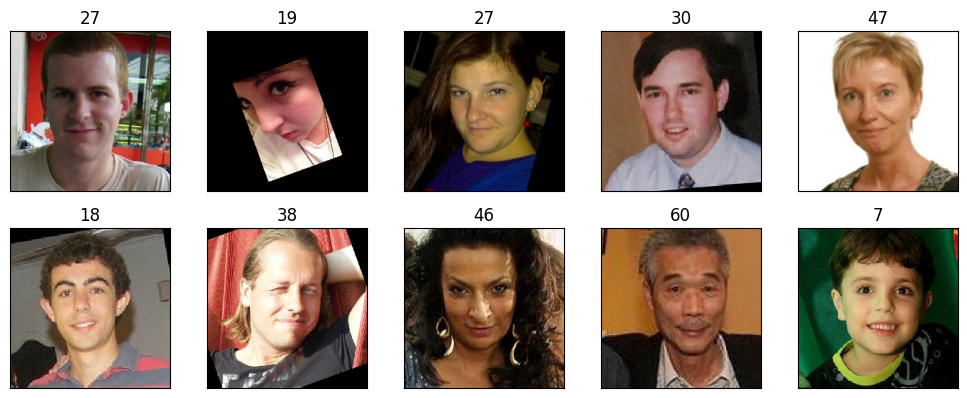

In [13]:
fig = plt.figure(figsize=(10,10))
for i in range(10):
    fig.add_subplot(5, 5, i+1)
    plt.imshow(features_train[i])
    plt.title(target_train[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

В качестве модели используем предобученная модель Resnet50 + Dropout + полносвязный слой с 256 нейроннами с функцией активации RELU + выходной слой с 1 нейроном с функцией активации RELU.

Конструируем модель.

In [14]:
model = create_model()
model.summary()


94765736/94765736 [==============================] - 4s 0us/step

model created

Model: "sequential"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  

                                                                 

 global_average_pooling2d (  (None, 2048)              0         

 GlobalAveragePooling2D)                                         

                                                                 

 dense (Dense)               (None, 256)               524544    

                                                                 

 dropout (Dropout)           (None, 256)               0         

                                                                 

 dense_1 (Dense)             (None, 1)                 257       

                                                                 


Total params: 24112513 (

Обучать модель будем на 100 эпохах с мониторингом темпа обучения и ранней остановкой.

In [15]:
model = train_model(model, train_data, test_data, epochs=100)

Epoch 1/100

178/178 [==============================] - 398s 488ms/step - loss: 184.9863 - mean_absolute_error: 10.0278 - val_loss: 510.6035 - val_mean_absolute_error: 17.5357 - lr: 2.0000e-04

Epoch 2/100

178/178 [==============================] - 82s 459ms/step - loss: 71.7519 - mean_absolute_error: 6.4087 - val_loss: 557.1796 - val_mean_absolute_error: 18.5187 - lr: 2.0000e-04

Epoch 3/100

178/178 [==============================] - 82s 459ms/step - loss: 41.1458 - mean_absolute_error: 4.9198 - val_loss: 251.0478 - val_mean_absolute_error: 11.8711 - lr: 2.0000e-04

Epoch 4/100

178/178 [==============================] - 82s 460ms/step - loss: 29.7539 - mean_absolute_error: 4.1090 - val_loss: 142.4813 - val_mean_absolute_error: 9.1677 - lr: 2.0000e-04

Epoch 5/100

178/178 [==============================] - 82s 460ms/step - loss: 25.3907 - mean_absolute_error: 3.8167 - val_loss: 82.8253 - val_mean_absolute_error: 6.7144 - lr: 2.0000e-04

Epoch 6/100

178/178 [=======================

На 49 эпохе обучение закончилось, итоговое значение MAE - 5.8.

Посмотрим как менялась метрика в процессе обучения.

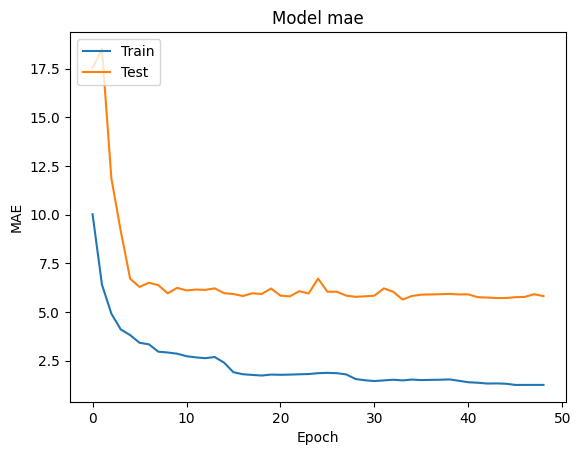

In [16]:
plot_metrics(model)

Сохраним модель.

In [17]:
model.save('my_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

  saving_api.save_model(


# Вывод

В результате выполнения проекта была разработана модель для предсказания возраста по фотографии,  после обучения модели мы получили метрику MAE 5.8 на тестовых данных.